## Tom Brady tracking data defense analysis

##### By Will Morgan, Head of AMF Data Science, StatsBomb

With the release of our latest tracking dataset for the 2020 season, we're going to dig into the defensive side of the ball. Specifically we'll examine how the secondary drops into coverage and how safeties line-up pre-and-post snap.

A reminder that documentation for the dataset can be found [here](https://github.com/statsbomb/amf-open-data/tree/main/doc). Our [previous introduction](https://colab.research.google.com/drive/1yDlTc2i-ycyVf02OKJbEjTfrmN0wBPLR?usp=sharing) to the tracking data might be useful too.

In [ ]:
import gzip
import json
from typing import List, Literal, Optional

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from requests import get
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans

In [ ]:
!pip install gif

In [ ]:
import gif

In [ ]:
pd.set_option('display.max_columns', None)

First we need to load and parse the tracking data using the function below. We added a [file](https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/games.json) containing meta-data for each game in the dataset and a link to the tracking data.

In [ ]:

Y_MAX = 160 / 3
GAMES_URL = (
    "https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/games.json"
)


def parse_tracking_file(file_path: str) -> pd.DataFrame:
    sb_tracking = json.loads(gzip.decompress(get(file_path).content))
    tracks = pd.json_normalize(
        sb_tracking,
        ["plays", "tracks", "steps"],
        meta=[
            "game_id",
            "nfl_game_id",
            "season_name",
            "game_date",
            ["plays", "play_uuid"],
            ["plays", "gsis_play_id"],
            ["plays", "start_timestamp"],
            ["plays", "end_timestamp"],
            ["plays", "play_offense_team_id"],
            ["plays", "offense_left_to_right"],
            ["plays", "play_type"],
            ["plays", "play_yardline"],
            ["plays", "play_down"],
            ["plays", "play_yards_to_go"],
            ["plays", "play_yards_net"],
            ["plays", "calibration_fault_ratio"],
            ["plays", "tracks", "nfl_team_id"],
            ["plays", "tracks", "team_id"],
            ["plays", "tracks", "player", "player_id"],
            ["plays", "tracks", "player", "name"],
            ["plays", "tracks", "player", "jersey_number"],
            ["plays", "tracks", "player", "position_code"],
            ["plays", "tracks", "on_camera_ratio"],
        ],
    )
    tracks.columns = [x.split(".")[-1] for x in tracks.columns]
    tracks["frame_index"] = (
        tracks.groupby("play_uuid")["time_since_snap"].rank("dense") - 1
    )

    tracks["x_orig"] = tracks["x"]
    tracks["y_orig"] = tracks["y"]
    tracks["x"] = np.where(
        (tracks["offense_left_to_right"] == False), 100 - tracks["x"], tracks["x"]
    )
    tracks["y"] = np.where(
        (tracks["offense_left_to_right"] == False), Y_MAX - tracks["y"], tracks["y"]
    )
    tracks["x_norm"] = tracks["x"] - tracks["play_yardline"]

    tracks["offense"] = np.where(
        tracks["play_offense_team_id"] == tracks["team_id"], True, False
    )

    return tracks


def load_tracking(season: int, limit: Optional[int] = None) -> pd.DataFrame:
    games = [
        g["url"]
        for g in json.loads(get(GAMES_URL).content)
        if g["season_name"] == season
    ]
    if limit:
        games = games[:limit]
    tracking_ = []
    for n, game in enumerate(games):
        print(f"Loading game {n+1} of {len(games)} from the {season} season: {game}")
        tracking = parse_tracking_file(game)
        tracking_.append(tracking)
    return pd.concat(tracking_)

This may take a moment or two as we're loading in quite a lot of (free!) data - we'll limit it to 5 games from each season in this example to keep things manageable.

In [ ]:
tracks = pd.concat([load_tracking(season, limit=5) for season in [2020, 2021, 2022]])

Loading game 1 of 5 from the 2020 season: https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/tracking/SB_tracking_20200913_TB_NO.json.gz
Loading game 2 of 5 from the 2020 season: https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/tracking/SB_tracking_20200920_CAR_TB.json.gz
Loading game 3 of 5 from the 2020 season: https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/tracking/SB_tracking_20200927_TB_DEN.json.gz
Loading game 4 of 5 from the 2020 season: https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/tracking/SB_tracking_20201004_LAC_TB.json.gz
Loading game 5 of 5 from the 2020 season: https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/tracking/SB_tracking_20201008_TB_CHI.json.gz
Loading game 1 of 5 from the 2021 season: https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/tracking/SB_tracking_20210909_DAL_TB.json.gz
Loading game 2 of 5 from the 2021 season: https://raw.githubusercontent

In [ ]:
tracks.head()

timestamp      x      y   ngs_x   ngs_y  time_since_snap  game_id  \
0   43200000  24.27  18.03  235.62  138.18           -7.679  1503686   
1   43233333  24.27  18.02  235.62  138.12           -7.646  1503686   
2   43266666  24.27  18.02  235.62  138.12           -7.612  1503686   
3   43300000  24.27  18.02  235.62  138.12           -7.579  1503686   
4   43333333  24.28  18.01  235.68  138.06           -7.546  1503686   

     nfl_game_id season_name   game_date  \
0  2020_01_TB_NO   2020/2021  2020-09-13   
1  2020_01_TB_NO   2020/2021  2020-09-13   
2  2020_01_TB_NO   2020/2021  2020-09-13   
3  2020_01_TB_NO   2020/2021  2020-09-13   
4  2020_01_TB_NO   2020/2021  2020-09-13   

                              play_uuid gsis_play_id start_timestamp  \
0  0529db6b-79a9-4406-9405-b3f2944e5a9f           55        43224308   
1  0529db6b-79a9-4406-9405-b3f2944e5a9f           55        43224308   
2  0529db6b-79a9-4406-9405-b3f2944e5a9f           55        43224308   
3  0529db6b-79a9-4406-9405-b3f2944e5a9f           55        43224308   
4  0529db6b-79a9-4406-9405-b3f2944e5a9f           55        43224308   

  end_timestamp play_offense_team_id offense_left_to_right play_type  \
0      57035044              1001295                  True      Pass   
1      57035044              1001295                  True      Pass   
2      57035044              1001295                  True      Pass   
3      57035044              1001295                  True      Pass   
4      57035044              1001295                  True      Pass   

  play_yardline play_down play_yards_to_go play_yards_net  \
0            25         1               10             14   
1            25         1               10             14   
2            25         1               10             14   
3            25         1               10             14   
4            25         1               10             14   

  calibration_fault_ratio nfl_team_id  team_id player_id            name  \
0                     0.0          NO  1001295   1024379  Michael Thomas   
1                     0.0          NO  1001295   1024379  Michael Thomas   
2                     0.0          NO  1001295   1024379  Michael Thomas   
3                     0.0          NO  1001295   1024379  Michael Thomas   
4                     0.0          NO  1001295   1024379  Michael Thomas   

  jersey_number position_code on_camera_ratio  frame_index  x_orig  y_orig  \
0            13            WR             1.0          0.0   24.27   18.03   
1            13            WR             1.0          1.0   24.27   18.02   
2            13            WR             1.0          2.0   24.27   18.02   
3            13            WR             1.0          3.0   24.27   18.02   
4            13            WR             1.0          4.0   24.28   18.01   

  x_norm  offense calibration_fault  
0  -0.73     True               NaN  
1  -0.73     True               NaN  
2  -0.73     True               NaN  
3  -0.73     True               NaN  
4  -0.72     True               NaN

The following is a helper function to plot a field on an existing axis. There are options for the orientation of the field to be plotted, whether to use NFL or NCAA hash markings, colors and how to annotate yardlines.

In [ ]:
X_MIN = -10
X_MAX = 110
Y_MIN = 0
Y_MAX = 160 / 3
Y_MID = (Y_MAX - Y_MIN) / 2

GOAL_WIDTH = 6.166667  # 18 feet 6 inches
LHS_POST = Y_MID - (GOAL_WIDTH / 2)
RHS_POST = Y_MID + (GOAL_WIDTH / 2)
CROSSBAR = 3.3  # 10 feet
POST_HEIGHT = 11.6667  # 35 feet

NFL_HASH = 23.583333  # 70 feet 9 inches
NCAA_HASH = 20.0  # 60 feet


def field(
    ax: plt.axes,
    orientation: Literal["horizontal", "vertical"],
    level: Literal["NFL", "NCAA"],
    background_color: str = "#F2F2F2",
    patch_color: str = "#CCCCCC",
    line_color: str = "#999999",
    normalise_los: bool = False,
) -> plt.axes:
    hash_mark = NCAA_HASH if level == "NCAA" else NFL_HASH
    hash_left = hash_mark
    hash_right = Y_MAX - hash_mark

    x_extent = [X_MIN, X_MIN, X_MIN, X_MAX, X_MAX, X_MAX, X_MAX, X_MIN]
    y_extent = [Y_MIN, Y_MAX, Y_MIN, Y_MIN, Y_MAX, Y_MAX, Y_MAX, Y_MAX]

    ax.plot(
        x_extent if orientation == "horizontal" else y_extent,
        y_extent if orientation == "horizontal" else x_extent,
        color=line_color,
        lw=1,
    )

    for b in [0.0, 100.0]:
        ax.plot(
            [b, b] if orientation == "horizontal" else [Y_MIN, Y_MAX],
            [Y_MIN, Y_MAX] if orientation == "horizontal" else [b, b],
            color=line_color,
            lw=1,
            zorder=1,
        )

    canvas = patches.Rectangle(
        (0, 0),
        100 if orientation == "horizontal" else Y_MAX,
        Y_MAX if orientation == "horizontal" else 100,
        linewidth=0.1,
        edgecolor=line_color,
        facecolor=background_color,
        zorder=0,
    )
    ax.add_patch(canvas)

    for n, line in enumerate(np.arange(0.0, 100.0, 10)):
        ax.plot(
            [line, line] if orientation == "horizontal" else [Y_MIN, Y_MAX],
            [Y_MIN, Y_MAX] if orientation == "horizontal" else [line, line],
            color=line_color,
            zorder=1,
            alpha=0.5,
        )
        if n % 2 == 0:
            patch = patches.Rectangle(
                (line, Y_MIN) if orientation == "horizontal" else (Y_MIN, line),
                10 if orientation == "horizontal" else Y_MAX,
                Y_MAX if orientation == "horizontal" else 10,
                linewidth=0.1,
                edgecolor=line_color,
                facecolor=patch_color,
                zorder=1,
            )
            ax.add_patch(patch)

    for dash_line in np.arange(5.0, 100.0, 5):
        ax.plot(
            [dash_line, dash_line] if orientation == "horizontal" else [Y_MIN, Y_MAX],
            [Y_MIN, Y_MAX] if orientation == "horizontal" else [dash_line, dash_line],
            ls="--",
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )

    for x in np.linspace(1, 99, 99):
        ax.plot(
            [x, x] if orientation == "horizontal" else [Y_MIN, 0.7],
            [Y_MIN, 0.7] if orientation == "horizontal" else [x, x],
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )
        ax.plot(
            [x, x] if orientation == "horizontal" else [Y_MAX, Y_MAX - 0.7],
            [Y_MAX, Y_MAX - 0.7] if orientation == "horizontal" else [x, x],
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )
        ax.plot(
            [x, x] if orientation == "horizontal" else [hash_left, hash_left - 0.7],
            [hash_left, hash_left - 0.7] if orientation == "horizontal" else [x, x],
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )
        ax.plot(
            [x, x] if orientation == "horizontal" else [hash_right, hash_right + 0.7],
            [hash_right, hash_right + 0.7] if orientation == "horizontal" else [x, x],
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )

    coords = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    values = (
        ["10", "20", "30", "40", "50", "40", "30", "20", "10"]
        if normalise_los is False
        else ["-10", "LOS", "10", "20", "30", "40", "50", "60", "70"]
    )
    for x, v in zip(coords, values):
        ax.annotate(
            v,
            (x, Y_MAX + 1.5) if orientation == "horizontal" else (Y_MAX + 2, x),
            ha="center",
            va="center",
            color=line_color,
        )
        ax.annotate(
            v,
            (x, Y_MIN - 1.5) if orientation == "horizontal" else (Y_MIN - 2, x),
            ha="center",
            va="center",
            color=line_color,
        )

    x_lim = -11, 111
    y_lim = Y_MAX + 2, -2

    ax.set_xlim(x_lim if orientation == "horizontal" else y_lim)
    ax.set_ylim(y_lim if orientation == "horizontal" else x_lim)

    ax.axis("off")

    return ax

#### Automatic defensive level detection

Our goal in the following analysis is to dynamically detect where the defense is located on each level and how many players are on each line. If we assume a three-level defense, that would encompass the linemen on the first level, the second level positioned underneath and the third level located deeper in coverage.

We're going to employ a fairly simple method that clusters a frame based on the x-coordinate of each player. In the example below, we'll use the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) library from [scikit-learn](https://scikit-learn.org/stable/index.html) with a fixed number of clusters equal to three (to represent our 3-level defense). N.B. We could use alternative clustering methods that automate the detection of the number of clusters, such as [AffinityPropagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html), but here we'll keep things simpler.

In [ ]:
def frame_plot(
    frame: pd.DataFrame, ax: plt.axes, offense_color: str, defense_colors: List[str]
):
    offense = frame.query("offense == True").copy()
    for jersey, player_frame in offense.groupby("jersey_number"):
        ax.plot(
            player_frame["x"],
            player_frame["y"],
            "o",
            markersize=15,
            color=offense_color,
        )
        ax.annotate(
            str(jersey),
            (player_frame.iloc[0]["x"], player_frame.iloc[0]["y"]),
            ha="center",
            va="center",
            color="w",
        )

    defense = frame.query("offense == False").copy()
    model = KMeans(n_clusters=3, random_state=42, n_init=10)
    model.fit(defense["x"].values.reshape(-1, 1))
    defense["cluster"] = model.labels_

    clusters = pd.DataFrame({"cluster": [0, 1, 2], "x": model.cluster_centers_[:, 0]})
    clusters["line"] = clusters["x"].rank().astype(int) - 1
    defense = pd.merge(
        defense,
        clusters[["cluster", "line"]],
        on="cluster",
    )

    for (jersey, line), player_frame in defense.groupby(["jersey_number", "line"]):
        ax.plot(
            player_frame["x"],
            player_frame["y"],
            "o",
            markersize=15,
            color=defense_colors[line],
        )
        ax.annotate(
            str(jersey),
            (player_frame.iloc[0]["x"], player_frame.iloc[0]["y"]),
            ha="center",
            va="center",
            color="w",
        )

    for line, x in zip(clusters["line"], clusters["x"]):
        ax.plot([x, x], [Y_MIN, Y_MAX], ls="--", zorder=1, color=defense_colors[line])
        n_players = defense.query(f"line == {line}")["jersey_number"].nunique()
        ax.annotate(
            str(n_players),
            (x + 1, Y_MAX - 1),
            ha="center",
            va="center",
            color=defense_colors[line],
            size=15,
        )

    ax.set_title(
        f"Time-since-snap: {frame.iloc[0]['time_since_snap']} seconds", loc="left"
    )

    return ax


def play_plotter(
    frames: pd.DataFrame,
    frame_index: int,
    offense_color: str = "#e21017",
    defense_colors: List[str] = ["#4ACBCE", "#0044CC", "#040482"],
) -> plt.figure:
    fig, ax = plt.subplots(figsize=(12, 5.3))
    field(ax, orientation="horizontal", level="NFL", normalise_los=False)
    frame_plot(
        frames.query(f"frame_index == {frame_index}").copy(),
        ax,
        offense_color,
        defense_colors,
    )
    return fig

In [ ]:
play_uuid = "08bdb828-1dcc-46c2-ab80-8d08c3943755"
play = tracks.query(f"play_uuid == '{play_uuid}' & time_since_snap > -1 & time_since_snap < 2").copy()

In the play below, we plot the offense in <span style="color:#e21017">red</span> with each level of the defense colored in various blues for the <span style="color:#4ACBCE">first</span>, <span style="color:#0044CC">second</span> and <span style="color:#040482">third</span> levels.

Examining the frame one-second pre-snap, on the first-level we have 6 players with 4 linemen on the ball, with #26 set slightly back and #22 in press-coverage on #13. On the third-level we have a single deep safety (#23).

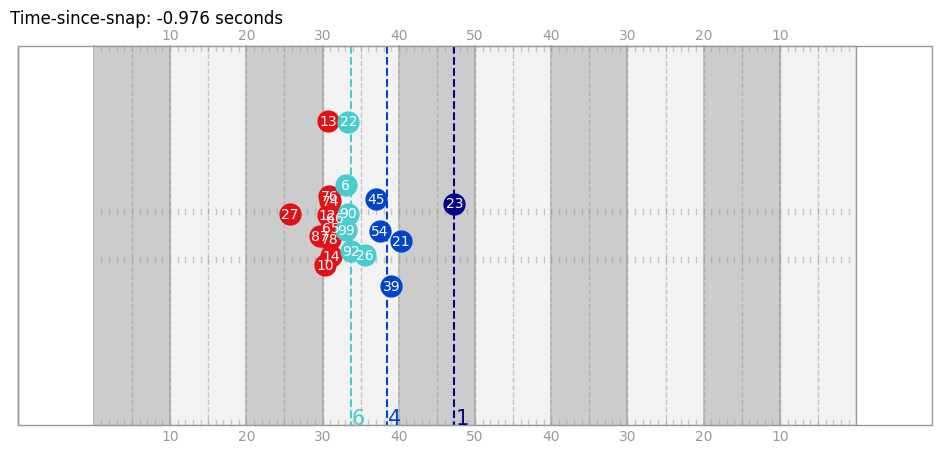

In [ ]:
fig = play_plotter(play, frame_index=play["frame_index"].min())

Contrasting that one-second post-snap, #26 firmly dropped back into the second-level having originally lined-up just off the line-of-scrimmage. We can see that #21 has dropped back to the third-level to form a two-safety look post-snap.

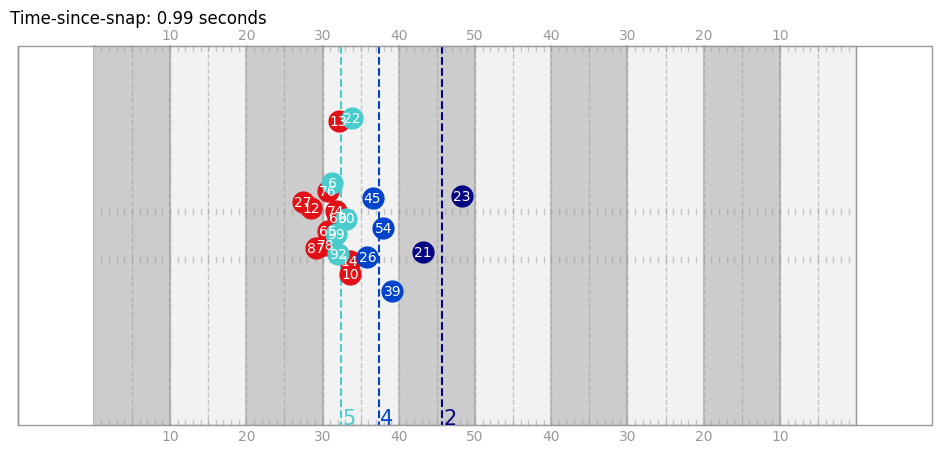

In [ ]:
fig = play_plotter(play, frame_index=112)

OK, so static plots of a single frame are _fine_, but what would a tracking data exploration be without an animation of moving dots?

In [ ]:
@gif.frame
def animate_play(
    frames: pd.DataFrame,
    frame_index: int,
):
    _ = play_plotter(
        frames,
        frame_index,
    )

play_list_ = [animate_play(play, frame_index) for frame_index in play["frame_index"].unique()]

In [ ]:
gif.save(
    play_list_,
    "tracking_play.gif",
    duration=(play["time_since_snap"].max() - play["time_since_snap"].min()) * 4,
)

The dots, they move!

We can see the initial pass rush by the linemen, with the second and third levels dropping back into coverage as the play evolves.

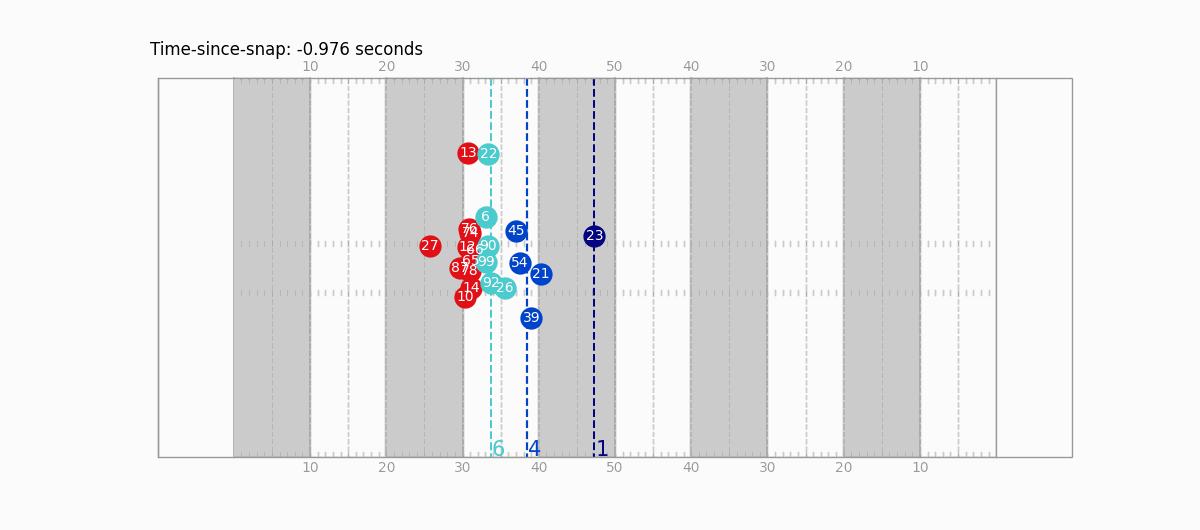

In [ ]:
Image(open('tracking_play.gif','rb').read())

The above was for a single play, so let's expand the analysis to the _whole_ dataset and see if we can glean any insights...

We'll pull out frames on passing plays approximately 1 second pre-snap and 1 second post-snap, which we'll then compare.

In [ ]:
pre_snap = tracks.query("time_since_snap > -1 and offense == False and play_type == 'Pass'").drop_duplicates(["game_id", "play_uuid", "player_id"], keep="first").copy()

In [ ]:
post_snap = tracks.query("time_since_snap < 1 and offense == False and play_type == 'Pass'").drop_duplicates(["game_id", "play_uuid", "player_id"], keep="last").copy()

Sometimes players go off camera, so their locations are `nan` in the data, so we'll filter those out.

In [ ]:
pre_snap = pre_snap.loc[pre_snap["x"].notnull()].copy()
post_snap = post_snap.loc[post_snap["x"].notnull()].copy()

We're going to write a function to run `KMeans` on all of the frames in our pre- and post-snap subsets, as well as calculating which level each cluster belongs to based on the mean normalised `x` coordinate of each cluster.

In [ ]:
def fit_kmeans(frame: pd.DataFrame, model: BaseEstimator):
    model.fit(frame["x_norm"].values.reshape(-1, 1))
    return model.labels_


def line_detection(frames: pd.DataFrame, n_clusters: int):
    frames = frames.sort_values(["play_uuid", "frame_index"]).reset_index(drop=True)
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    frames["cluster"] = frames.groupby("play_uuid").apply(lambda x: fit_kmeans(x, model)).explode().values
    frames["line"] = frames.groupby(["play_uuid", "cluster"])[["x_norm"]].transform("mean")
    frames["level"] = frames.groupby("play_uuid")["line"].rank("dense").astype(int)
    return frames

In [ ]:
pre_snap = line_detection(pre_snap, 3)

In [ ]:
post_snap = line_detection(post_snap, 3)

We'll add a short helper function to summarise the data by calculating the mean depth and count of players at each level.

In [ ]:
def line_summary(frames: pd.DataFrame, prefix: str) -> pd.DataFrame:
    frame_stats = frames.groupby(["game_id", "play_uuid", "nfl_team_id", "line", "level"], as_index=False)[["player_id"]].count()
    frame_pivot = frame_stats.pivot_table(index=["game_id", "play_uuid", "nfl_team_id"], columns="level", values=["line", "player_id"]).reset_index()
    frame_pivot.columns = ["game_id", "play_uuid", "nfl_team_id", f"{prefix}_x_l1", f"{prefix}_x_l2", f"{prefix}_x_l3", f"{prefix}_count_l1", f"{prefix}_count_l2", f"{prefix}_count_l3"]
    return frame_pivot

In [ ]:
pre_snap_summary = line_summary(pre_snap, "pre_snap")
pre_snap_summary.head()

game_id                             play_uuid nfl_team_id  pre_snap_x_l1  \
0  1069736  0278fbce-00b2-4b39-bce6-32d2f4cbbf66          TB       1.052000   
1  1069736  0294279e-8612-4b29-9ab5-c4cc7a2f9d11          TB       1.831667   
2  1069736  04d6aeea-b575-4b66-8575-c03400c9bbc2          TB       1.572000   
3  1069736  06148b76-ea53-46a0-a3c5-91d618e29c05          LA       0.812500   
4  1069736  073913af-8742-4bd7-a4cf-ccd97974813b          LA       0.970000   

   pre_snap_x_l2  pre_snap_x_l3  pre_snap_count_l1  pre_snap_count_l2  \
0       3.840000      10.486667                  5                  3   
1       6.660000      11.455000                  6                  3   
2       4.725000       9.600000                  5                  4   
3       2.795000       9.533333                  4                  4   
4       4.426667       9.170000                  6                  3   

   pre_snap_count_l3  
0                  3  
1                  2  
2                  2  
3                  3  
4                  2

In [ ]:
post_snap_summary = line_summary(post_snap, "post_snap")
post_snap_summary.head()

game_id                             play_uuid nfl_team_id  post_snap_x_l1  \
0  1069736  0278fbce-00b2-4b39-bce6-32d2f4cbbf66          TB       -0.717500   
1  1069736  0294279e-8612-4b29-9ab5-c4cc7a2f9d11          TB       -2.136667   
2  1069736  04d6aeea-b575-4b66-8575-c03400c9bbc2          TB        0.302000   
3  1069736  06148b76-ea53-46a0-a3c5-91d618e29c05          LA       -0.692500   
4  1069736  073913af-8742-4bd7-a4cf-ccd97974813b          LA       -2.592500   

   post_snap_x_l2  post_snap_x_l3  post_snap_count_l1  post_snap_count_l2  \
0          4.3640          14.085                   4                   5   
1          4.2825           9.955                   3                   4   
2          5.8760          15.000                   5                   5   
3          3.1650          11.150                   4                   4   
4          3.1200           8.480                   4                   4   

   post_snap_count_l3  
0                   2  
1                   4  
2                   1  
3                   3  
4                   3

Combine those into one dataframe and we can start looking at how things compare before and after the snap.

In [ ]:
play_levels = pd.merge(
    pre_snap_summary,
    post_snap_summary,
    on=["game_id", "play_uuid", "nfl_team_id"],
    how="inner"
)
play_levels["depth_delta_l3"] = play_levels["post_snap_x_l3"] - play_levels["pre_snap_x_l3"]
play_levels["level3_alignment"] = play_levels["pre_snap_count_l3"].astype(str) + "-" + play_levels["post_snap_count_l3"].astype(str)
play_levels.head()

game_id                             play_uuid nfl_team_id  pre_snap_x_l1  \
0  1069736  0278fbce-00b2-4b39-bce6-32d2f4cbbf66          TB       1.052000   
1  1069736  0294279e-8612-4b29-9ab5-c4cc7a2f9d11          TB       1.831667   
2  1069736  04d6aeea-b575-4b66-8575-c03400c9bbc2          TB       1.572000   
3  1069736  06148b76-ea53-46a0-a3c5-91d618e29c05          LA       0.812500   
4  1069736  073913af-8742-4bd7-a4cf-ccd97974813b          LA       0.970000   

   pre_snap_x_l2  pre_snap_x_l3  pre_snap_count_l1  pre_snap_count_l2  \
0       3.840000      10.486667                  5                  3   
1       6.660000      11.455000                  6                  3   
2       4.725000       9.600000                  5                  4   
3       2.795000       9.533333                  4                  4   
4       4.426667       9.170000                  6                  3   

   pre_snap_count_l3  post_snap_x_l1  post_snap_x_l2  post_snap_x_l3  \
0                  3       -0.717500          4.3640          14.085   
1                  2       -2.136667          4.2825           9.955   
2                  2        0.302000          5.8760          15.000   
3                  3       -0.692500          3.1650          11.150   
4                  2       -2.592500          3.1200           8.480   

   post_snap_count_l1  post_snap_count_l2  post_snap_count_l3  depth_delta_l3  \
0                   4                   5                   2        3.598333   
1                   3                   4                   4       -1.500000   
2                   5                   5                   1        5.400000   
3                   4                   4                   3        1.616667   
4                   4                   4                   3       -0.690000   

  level3_alignment  
0              3-2  
1              2-4  
2              2-1  
3              3-3  
4              2-3

As we might expect (even in a small and biased sample), we typically see two-high and single-high safety coverages that are maintained over the course of the play (over 50% of the time here). If we do see a shift, it tends to be from 1-deep safety pre-snap, with a second dropping back post-snap on about 10% of the plays here.

In [ ]:
level3_alignment = play_levels.groupby("level3_alignment", as_index=False)[["play_uuid"]].count()
level3_alignment["play_prop"] = level3_alignment["play_uuid"] / level3_alignment["play_uuid"].sum()
level3_alignment.sort_values("play_uuid", ascending=False)

level3_alignment  play_uuid  play_prop
0               1-1        392   0.302003
7               2-2        343   0.264253
1               1-2        133   0.102465
13              3-3        101   0.077812
8               2-3         80   0.061633
2               1-3         53   0.040832
6               2-1         52   0.040062
9               2-4         43   0.033128
19              4-4         24   0.018490
3               1-4         19   0.014638
14              3-4         17   0.013097
12              3-2         12   0.009245
11              3-1          8   0.006163
20              5-5          5   0.003852
10              2-5          4   0.003082
18              4-3          3   0.002311
15              3-5          2   0.001541
16              4-1          2   0.001541
17              4-2          2   0.001541
4               1-5          2   0.001541
5               1-6          1   0.000770

There is of course a hugely contextual element to these observations, for example on the play below we have 3 players deep pre-snap (2 safeties & 1 corner) and they stay deep as the play progresses. The context here is 3rd-and-20 on the offense's 13 yard line, so the defense is set accordingly.

Such situational context can also explain some of the more extreme and rare arrangements noted in the table.

In [ ]:
example_play = tracks.query("play_uuid == '20ec5cc2-a514-4201-af69-1ceea1b84550' and time_since_snap > -1 and time_since_snap < 2").copy()

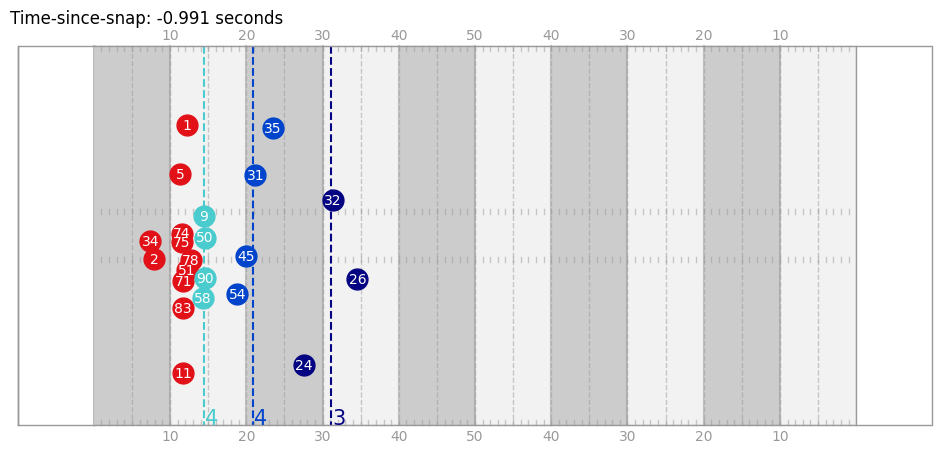

In [ ]:
fig = play_plotter(example_play, frame_index=example_play["frame_index"].min())

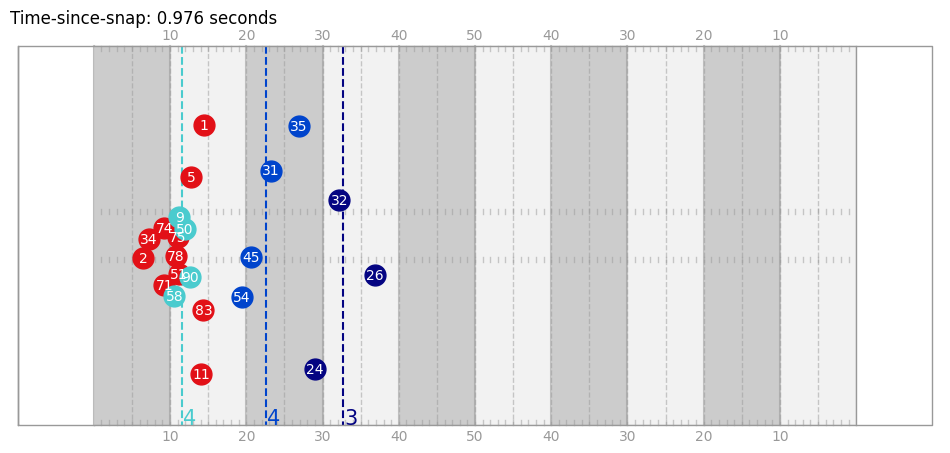

In [ ]:
fig = play_plotter(example_play, frame_index=129)

In [ ]:
play_list_ = [animate_play(example_play, frame_index) for frame_index in example_play["frame_index"].unique()]

In [ ]:
gif.save(
    play_list_,
    "tracking_play2.gif",
    duration=(example_play["time_since_snap"].max() - example_play["time_since_snap"].min()) * 4,
)

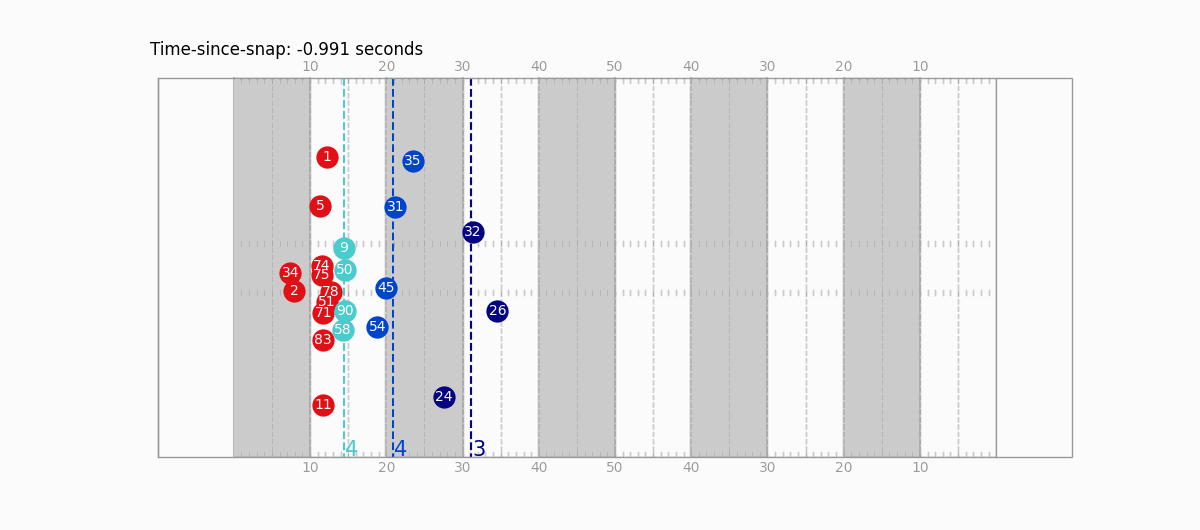

In [ ]:
Image(open('tracking_play2.gif','rb').read())

## Appendix - joining with nflfastR data

Below is an exercise in joining nflfastR data, which could be used to generate further analysis (in larger sample sizes, of course).

In [ ]:
play_mapping = tracks.drop_duplicates(["game_id", "play_uuid"])[["game_id", "play_uuid", "nfl_game_id", "gsis_play_id"]].rename(columns={"game_id": "sb_game_id", "play_uuid": "sb_play_uuid", "nfl_game_id": "game_id", "gsis_play_id": "play_id"})
play_mapping.head()

sb_game_id                          sb_play_uuid        game_id play_id
0        1503686  0529db6b-79a9-4406-9405-b3f2944e5a9f  2020_01_TB_NO      55
8776     1503686  616b849b-1386-48fb-8e44-9b758ef9ba80  2020_01_TB_NO      83
13264    1503686  1342526e-0883-4ed1-968d-7bfc0db26604  2020_01_TB_NO     104
19028    1503686  1b73b87e-cf90-40b8-9eb7-05c2772679a6  2020_01_TB_NO     128
25232    1503686  61b2c304-728d-46d0-91d4-e9853b769593  2020_01_TB_NO     179

In [ ]:
nflfastr_pbp_files = [
    "https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_2022.parquet",
    "https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_2021.parquet",
    "https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_2020.parquet",

]
nflfastr_pbp = pd.concat(pd.read_parquet(file) for file in nflfastr_pbp_files)

In [ ]:
nflfastr_pbp = pd.merge(
    nflfastr_pbp,
    play_mapping,
    on=["game_id", "play_id"],
    how="inner",
)

In [ ]:
nflfastr_pbp.head()

play_id         game_id old_game_id home_team away_team season_type  week  \
0    65.0  2022_01_TB_DAL  2022091113       DAL        TB         REG     1   
1    89.0  2022_01_TB_DAL  2022091113       DAL        TB         REG     1   
2   110.0  2022_01_TB_DAL  2022091113       DAL        TB         REG     1   
3   131.0  2022_01_TB_DAL  2022091113       DAL        TB         REG     1   
4   155.0  2022_01_TB_DAL  2022091113       DAL        TB         REG     1   

  posteam posteam_type defteam side_of_field  yardline_100   game_date  \
0     DAL         home      TB           DAL          86.0  2022-09-11   
1     DAL         home      TB           DAL          79.0  2022-09-11   
2     DAL         home      TB           DAL          72.0  2022-09-11   
3     DAL         home      TB           DAL          80.0  2022-09-11   
4     DAL         home      TB           DAL          69.0  2022-09-11   

   quarter_seconds_remaining  half_seconds_remaining  game_seconds_remaining  \
0                      896.0                  1796.0                  3596.0   
1                      859.0                  1759.0                  3559.0   
2                      828.0                  1728.0                  3528.0   
3                      789.0                  1689.0                  3489.0   
4                      755.0                  1655.0                  3455.0   

  game_half  quarter_end  drive   sp  qtr  down  goal_to_go   time   yrdln  \
0     Half1          0.0    1.0  0.0  1.0   1.0         0.0  14:56  DAL 14   
1     Half1          0.0    1.0  0.0  1.0   2.0         0.0  14:19  DAL 21   
2     Half1          0.0    1.0  0.0  1.0   1.0         0.0  13:48  DAL 28   
3     Half1          0.0    1.0  0.0  1.0   2.0         0.0  13:09  DAL 20   
4     Half1          0.0    1.0  0.0  1.0   3.0         0.0  12:35  DAL 31   

   ydstogo  ydsnet                                               desc  \
0     10.0    54.0  (14:56) (Shotgun) 4-D.Prescott pass short left...   
1      3.0    54.0  (14:19) 21-E.Elliott up the middle to DAL 28 f...   
2     10.0    54.0  (13:48) 20-T.Pollard up the middle to DAL 20 f...   
3     18.0    54.0  (13:09) (Shotgun) 4-D.Prescott pass short righ...   
4      7.0    54.0  (12:35) (Shotgun) 4-D.Prescott pass deep middl...   

  play_type  yards_gained  shotgun  no_huddle  qb_dropback  qb_kneel  \
0      pass           7.0      1.0        0.0          1.0       0.0   
1       run           7.0      0.0        0.0          0.0       0.0   
2       run          -8.0      0.0        0.0          0.0       0.0   
3      pass          11.0      1.0        0.0          1.0       0.0   
4      pass          16.0      1.0        0.0          1.0       0.0   

   qb_spike  qb_scramble pass_length pass_location  air_yards  \
0       0.0          0.0       short          left        3.0   
1       0.0          0.0        None          None        NaN   
2       0.0          0.0        None          None        NaN   
3       0.0          0.0       short         right        5.0   
4       0.0          0.0        deep        middle       16.0   

   yards_after_catch run_location run_gap field_goal_result  kick_distance  \
0                4.0         None    None              None            NaN   
1                NaN       middle    None              None            NaN   
2                NaN       middle    None              None            NaN   
3                6.0         None    None              None            NaN   
4                0.0         None    None              None            NaN   

  extra_point_result two_point_conv_result  home_timeouts_remaining  \
0               None                  None                      3.0   
1               None                  None                      3.0   
2               None                  None                      3.0   
3               None                  None                      3.0   
4               None                  None   

Behold, the nflverse at your finger tips! Please use responsibly.